In [ ]:
import json
import os
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import torch

# Paths
metadata_path = "../../ground_truth_dataset/multi_task_data3/test_hyp.json"
dataset_path = "../../ground_truth_dataset/alpaca_multi_task3/alpaca_test.jsonl"
results_output_path = "./evaluation/llama3-hyper-full2.json"

# Load model and tokenizer
base_model_path = "meta-llama/Llama-3.2-3B-Instruct"
fine_tuned_model_path = "./outputs/llama3.2-3B-hypER-mixed-lora-out-full2/merged/"

tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)
fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    fine_tuned_model_path,
    device_map="auto",
    torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)

pipe = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer)

generation_args = {
    "max_new_tokens": 50,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

# Load Alpaca dataset
def load_alpaca_dataset(file_path):
    with open(file_path, "r") as f:
        return [json.loads(line.strip()) for line in f]

# Load metadata (test_hyp.json)
def load_metadata(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
def filter_metadata(metadata):
    """Filter out entries where source or target abstract is missing."""
    filtered_metadata = []

    for entry in metadata:
        task_name = entry.get("task_name", "unknown")
        input_data = entry.get("input", {})

        if task_name == "hyper-1-hop":
            source_paper = input_data.get("source_paper", {})
            target_paper = input_data.get("target_paper", {})

            # Skip if abstracts are missing
            if not source_paper.get("abstract") or not target_paper.get("abstract"):
                continue  

        # If task is not hyper-1-hop, retain all metadata
        filtered_metadata.append(entry)

    return filtered_metadata
    
# Save predictions to JSON
def save_predictions(predictions, file_path):
    with open(file_path, "w") as f:
        json.dump(predictions, f, indent=2)
    print(f"Saved predictions to {file_path}")

# Inference function with metadata linking
def evaluate_model_on_dataset(alpaca_dataset, metadata, output_path):
    predictions = []

    # Ensure dataset and metadata have the same length
    assert len(alpaca_dataset) == len(metadata), "Mismatch in Alpaca dataset and metadata length!"

    print("Starting inference...")
    for index, entry in tqdm(enumerate(alpaca_dataset), total=len(alpaca_dataset)):
        # Get corresponding metadata
        task_metadata = metadata[index]

        instruction = entry["instruction"]
        input_text = entry["input"]
        actual_output_text = entry["output"]

        # Retrieve metadata fields
        task_name = task_metadata.get("task_name", "unknown")
        file_name = task_metadata.get("file_name", "unknown")
        chain_label = task_metadata.get("chain_label", "unknown")
        file_path = task_metadata.get("file_path", "unknown")

        # Prepare system prompt
        messages = [
            {"role": "system", "content": "You are a scientist evaluating scientific reasoning chains."},
            {"role": "user", "content": f"{instruction}\n{input_text}\n\nOutput:"},
        ]

        try:
            output = pipe(messages, **generation_args)
            predicted_output = output[0]['generated_text'].strip()

            if predicted_output is None:
                predicted_output = {"error": "Invalid JSON format"}
        except Exception as e:
            print(f"Error with entry: {entry}\nError: {e}")
            predicted_output = {"error": "Generation failed"}

        # Append metadata and prediction results
        predictions.append({
            "task_name": task_name,
            "file_name": file_name,
            "chain_label": chain_label,
            "file_path": file_path,
            "instruction": instruction,
            "input": input_text,
            "actual_output": actual_output_text,
            "predicted_output": predicted_output
        })

    save_predictions(predictions, output_path)

# Load datasets
alpaca_dataset = load_alpaca_dataset(dataset_path)
metadata = load_metadata(metadata_path)
filtered_metadata = filter_metadata(metadata)

# Run inference and save results
evaluate_model_on_dataset(alpaca_dataset, filtered_metadata, results_output_path)


In [1]:
import json
import re
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict

# Path to saved predictions
results_output_path = "./evaluation/llama3-base-full2.json"

# Load predictions JSON
def load_predictions(file_path):
    """Load saved predictions from JSON."""
    with open(file_path, "r") as f:
        return json.load(f)

# Load the saved results
predictions = load_predictions(results_output_path)

# Initialize storage for task-wise results
task_results = defaultdict(lambda: {"y_true": [], "y_pred": [], "y_true_invalids": [], "y_pred_invalids": []})

# Normalize JSON output (remove formatting issues)
import re

def extract_validity_and_ids(json_str):
    """
    Extracts 'validity' status and any numeric paper IDs from a JSON string.
    Works even if the format is broken.
    """
    if not json_str or json_str.strip() == "":
        return None, []  # Return None if input is empty

    json_str = re.sub(r"```json|```", "", json_str)  # Removes '```json' and '```'
    json_str = re.sub(r"\s+", " ", json_str).strip() # Remove extra spaces and strip
    
    # Extract validity status (valid or invalid)
    validity_match = re.search(r'"validity"\s*:\s*"?(\bvalid\b|\binvalid\b)"?', json_str)

    validity = validity_match.group(1) if validity_match else None

    # Extract numbers from "invalid_paper_ids"
    invalid_ids = re.findall(r'\d+', json_str)  # Find all numbers

    return validity, list(map(int, invalid_ids))  # Convert numbers to integers


In [2]:
import json
import re

def extract_relevance_score(json_str):
    """
    Extracts the relevance score from a JSON string or integer input.
    Handles extra text, multiple JSONs, and unexpected formats.
    """
    if isinstance(json_str, int):
        return json_str  # ✅ Already an integer, return directly

    try:
        # Ensure input is a string
        if not isinstance(json_str, str):
            raise TypeError(f"Expected str or int, got {type(json_str)}")

        # Clean up formatting (remove triple quotes and spaces)
        json_str = re.sub(r"```json|```", "", json_str).strip()

        # Extract JSON-like part if mixed with extra text
        match = re.search(r'\{[^{}]*"relevance_score"[^{}]*\}', json_str)
        if match:
            json_str = match.group(0)  # Extract the first JSON object found

        # Parse JSON
        parsed_json = json.loads(json_str)  

        # If parsed JSON is directly an integer, return it
        if isinstance(parsed_json, int):
            return parsed_json

        # Extract relevance_score from different JSON structures
        if "relevance_score" in parsed_json:
            return int(parsed_json["relevance_score"])
        
        # Check nested structures for relevance_score
        for key, value in parsed_json.items():
            if isinstance(value, dict) and "relevance_score" in value:
                return int(value["relevance_score"])

        raise KeyError("relevance_score not found in JSON structure")

    except (json.JSONDecodeError, KeyError, ValueError, TypeError) as e:
        print(f"Error parsing relevance score from: {json_str}\nError: {e}")
        return None  # Return None if parsing fails


In [3]:
from tqdm import tqdm  

for index, entry in enumerate(tqdm(predictions, total=len(predictions))):
    task_name = entry["task_name"]
    actual_output = entry["actual_output"]
    predicted_output = entry["predicted_output"]

    if task_name == "hyper-1-hop":
        y_true = extract_relevance_score(actual_output)
        y_pred = extract_relevance_score(predicted_output)

    elif task_name in {"hyper-multi-hop2_c1", "hyper-multi-hop2_c2"}:
        y_true, y_true_invalids = extract_validity_and_ids(actual_output)
        y_pred, y_pred_invalids = extract_validity_and_ids(predicted_output)
        
        # Store invalid paper IDs
        task_results[task_name]["y_true_invalids"].append(y_true_invalids)
        task_results[task_name]["y_pred_invalids"].append(y_pred_invalids)

    else:
        continue  # Ignore unknown task names

    # Skip if extraction failed
    if y_true is None or y_pred is None:
        print(f"⚠️ Skipping entry {index} due to parsing issues.")
        continue

    # Store results in structured format
    task_results[task_name]["y_true"].append(y_true)
    task_results[task_name]["y_pred"].append(y_pred)

  0%|          | 0/1839 [00:00<?, ?it/s]

100%|██████████| 1839/1839 [00:00<00:00, 29476.29it/s]


In [4]:
# Compute Accuracy & Metrics for Each Task
for task, results in task_results.items():
    y_true = results["y_true"]
    y_pred = results["y_pred"]

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0)

    print(f"\nTask: {task}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(report)



🔹 Task: hyper-1-hop
✅ Accuracy: 35.16%
              precision    recall  f1-score   support

           0       1.00      0.19      0.32       574
           1       0.01      0.05      0.02        42
           2       0.36      0.87      0.51       203

    accuracy                           0.35       819
   macro avg       0.46      0.37      0.28       819
weighted avg       0.79      0.35      0.35       819


🔹 Task: hyper-multi-hop2_c1
✅ Accuracy: 58.24%
              precision    recall  f1-score   support

     invalid       0.55      0.84      0.67       253
       valid       0.68      0.33      0.44       257

    accuracy                           0.58       510
   macro avg       0.61      0.58      0.55       510
weighted avg       0.62      0.58      0.55       510


🔹 Task: hyper-multi-hop2_c2
✅ Accuracy: 55.10%
              precision    recall  f1-score   support

     invalid       0.56      0.43      0.49       253
       valid       0.54      0.67      0.60    

In [5]:
def precision_recall_f1_jaccard(y_pred_invalids, y_true_invalids):
    """
    Computes precision, recall, F1-score, and Jaccard similarity for invalid paper IDs.
    """
    precisions, recalls, f1s, jaccards = [], [], [], []
    
    for pred_set, true_set in zip(y_pred_invalids, y_true_invalids):
        pred_set, true_set = set(pred_set), set(true_set)

        intersection = len(pred_set & true_set)
        union = len(pred_set | true_set)

        precision = intersection / len(pred_set) if pred_set else 0
        recall = intersection / len(true_set) if true_set else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        jaccard = intersection / union if union > 0 else 1  # Jaccard similarity

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        jaccards.append(jaccard)

    # Compute mean metrics
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)
    avg_jaccard = np.mean(jaccards)

    return avg_precision, avg_recall, avg_f1, avg_jaccard


In [6]:
for task in ["hyper-multi-hop2_c1", "hyper-multi-hop2_c2"]:
    if task in task_results:
        precision, recall, f1, jaccard = precision_recall_f1_jaccard(
            task_results[task]["y_pred_invalids"], task_results[task]["y_true_invalids"]
        )

        print(f"\nTask: {task} (Invalid Paper ID Matching)")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Jaccard Similarity: {jaccard:.2f}")



🔹 Task: hyper-multi-hop2_c1 (Invalid Paper ID Matching)
✅ Precision: 0.09
✅ Recall: 0.19
✅ F1 Score: 0.11
✅ Jaccard Similarity: 0.24

🔹 Task: hyper-multi-hop2_c2 (Invalid Paper ID Matching)
✅ Precision: 0.06
✅ Recall: 0.09
✅ F1 Score: 0.06
✅ Jaccard Similarity: 0.39


In [10]:
np.mean([0.78 ,0.84, 0.84,0.32,0.30 ])
np.mean([0.17 ,0.77, 0.50,0.11,0.14 ])

0.33799999999999997

In [29]:
import json

# Paths
metadata_path = "../../ground_truth_dataset/balanced_splits_w_hyp/test_hyp.json"
predictions_path = "./evaluation/llama3-hyper-full2.json"
output_path = "./evaluation/llama3-hyper-full2-with-length.json"

# Load ground truth metadata (contains chain lengths)
with open(metadata_path, "r") as f:
    ground_truth_data = json.load(f)

# Create a mapping from multiple fields to chain length
chain_length_mapping = {}
for entry in ground_truth_data:
    key = (
        entry["file_name"],
        entry["file_path"],
        entry["chain_label"],
        entry.get("generated_from_split", False)  # Default to False if missing
    )
    chain_length_mapping[key] = len(entry.get("content", []))  # Extract chain length

# Load model predictions
with open(predictions_path, "r") as f:
    model_predictions = json.load(f)

# Add chain length to predictions
for entry in model_predictions:
    key = (
        entry["file_name"],
        entry["file_path"],
        entry["chain_label"],
        entry.get("generated_from_split", False)  # Default to False if missing
    )
    entry["chain_length"] = chain_length_mapping.get(key, None)  # Assign length, default to None if not found

# Save updated predictions with chain length
with open(output_path, "w") as f:
    json.dump(model_predictions, f, indent=2)

print(f"Updated predictions saved to {output_path}")


✅ Updated predictions saved to ./evaluation/llama3-hyper-full2-with-length.json


In [30]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from collections import defaultdict

# Path to predictions
predictions_path = "./evaluation/llama3-hyper-full2-with-length.json"

# Load predictions
with open(predictions_path, "r") as f:
    predictions_data = json.load(f)

# Categorize chain lengths
def categorize_length(length):
    if length <= 5:
        return "Low"
    elif 6 <= length <= 15:
        return "Moderate"
    elif 16 <= length <= 25:
        return "High"
    else:
        return "Very High"  # Edge case for longer chains

# Storage for task-wise results categorized by chain length
task_results_by_length = defaultdict(lambda: defaultdict(lambda: {"y_true": [], "y_pred": []}))

# Iterate through predictions
for entry in tqdm(predictions_data, total=len(predictions_data)):
    task_name = entry["task_name"]
    chain_length = entry.get("chain_length", None)

    if chain_length is None:
        continue  # Skip if length is missing

    length_category = categorize_length(chain_length)

    actual_output = entry["actual_output"]
    predicted_output = entry["predicted_output"]

    # Extract actual and predicted results based on task type
    if task_name == "hyper-1-hop":
        y_true = extract_relevance_score(actual_output)
        y_pred = extract_relevance_score(predicted_output)

    elif task_name in {"hyper-multi-hop2_c1", "hyper-multi-hop2_c2"}:
        y_true, _ = extract_validity_and_ids(actual_output)
        y_pred, _ = extract_validity_and_ids(predicted_output)

    else:
        continue  # Ignore unknown task names

    # Skip if extraction failed
    if y_true is None or y_pred is None:
        print(f"⚠️ Skipping entry due to parsing issues.")
        continue

    # Store results based on task & chain length category
    task_results_by_length[task_name][length_category]["y_true"].append(y_true)
    task_results_by_length[task_name][length_category]["y_pred"].append(y_pred)

# Compute classification metrics for each task and length category
final_results = []

for task, length_groups in task_results_by_length.items():
    for length_category, results in length_groups.items():
        y_true = results["y_true"]
        y_pred = results["y_pred"]

        if len(y_true) > 0:
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
            accuracy = accuracy_score(y_true, y_pred)
        else:
            precision, recall, f1, accuracy = 0, 0, 0, 0  # No data for this category

        final_results.append([task, length_category, len(y_true), accuracy, precision, recall, f1])

# Convert results to DataFrame
df_results = pd.DataFrame(final_results, columns=["Task", "Length Category", "Num Samples", "Accuracy", "Precision", "Recall", "F1-Score"])

# Print results
print("\nClassification Metrics by Chain Length\n")
print(df_results.to_string(index=False))


100%|██████████| 1839/1839 [00:00<00:00, 38285.99it/s]


🔹 Classification Metrics by Chain Length

               Task Length Category  Num Samples  Accuracy  Precision   Recall  F1-Score
        hyper-1-hop             Low           20  0.800000   0.708333 0.725000  0.699074
        hyper-1-hop        Moderate          458  0.805677   0.494210 0.592426  0.487415
        hyper-1-hop            High          147  0.768707   0.413664 0.508216  0.414855
hyper-multi-hop2_c1             Low           29  0.689655   0.682692 0.686275  0.683636
hyper-multi-hop2_c1        Moderate          233  0.824034   0.661255 0.657572  0.659369
hyper-multi-hop2_c1            High           49  0.918367   0.958333 0.600000  0.644928
hyper-multi-hop2_c2             Low           29  0.862069   0.875000 0.882353  0.861905
hyper-multi-hop2_c2        Moderate          233  0.931330   0.962441 0.777778  0.837631
hyper-multi-hop2_c2            High           49  0.959184   0.978261 0.800000  0.863889


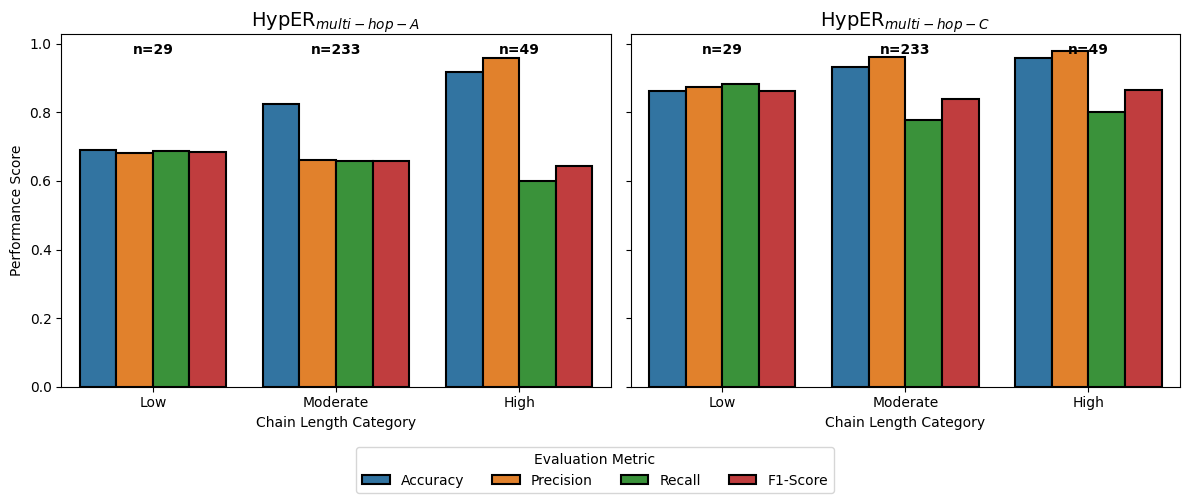

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df_results is already available as the DataFrame

# Filter out 'hyper-1-hop'
df_results = df_results[df_results["Task"] != "hyper-1-hop"]
plt.rc('text', usetex=False)  # Turn off LaTeX rendering

# Plot settings
fig, axes = plt.subplots(1, len(df_results["Task"].unique()), figsize=(12, 5), sharey=True)

# Ensure axes is iterable even for a single subplot
if len(df_results["Task"].unique()) == 1:
    axes = [axes]

tasks = df_results["Task"].unique()

for i, task in enumerate(tasks):
    ax = axes[i]
    task_df = df_results[df_results["Task"] == task]
    
    task_df_melted = task_df.melt(id_vars=["Length Category", "Num Samples"], 
                                  value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                                  var_name="Evaluation Metric", 
                                  value_name="Performance Score")
    
    sns.barplot(data=task_df_melted, x="Length Category", y="Performance Score", hue="Evaluation Metric", ax=ax, edgecolor="black",   # Set bar border color
        linewidth=1.5 )
    
    for j, row in task_df.iterrows():
        ax.text(j % 3, 0.97, f"n={row['Num Samples']}", ha='center', fontsize=10, fontweight='bold', color='black')
    if task == "hyper-multi-hop2_c1":
        ax.set_title("HypER$_{multi-hop-A}$", fontsize=14)

    else:
        ax.set_title("HypER$_{multi-hop-C}$", fontsize=14)


    ax.set_xlabel("Chain Length Category")
    ax.set_ylabel("Performance Score")
    ax.grid(False)  # Disable the grid

    
# Add legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, title="Evaluation Metric", bbox_to_anchor=(0.5, -0.01))
for ax in axes:
    ax.get_legend().remove()

plt.tight_layout(rect=[0, 0.1, 1, 1])
#plt.savefig("performance_length.pdf", format="pdf", bbox_inches="tight")

plt.show()


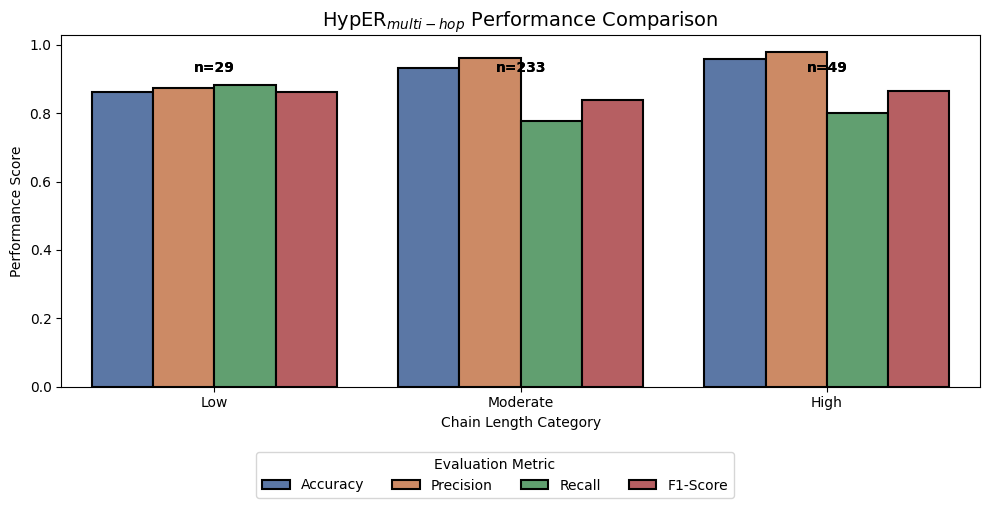

In [34]:
# Ensure correct data processing before plotting
df_results_filtered = df_results[df_results["Task"] != "hyper-1-hop"]


# Melt the dataframe for seaborn plotting
df_melted = df_results_filtered.melt(
    id_vars=["Task", "Length Category", "Num Samples"],
    value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
    var_name="Evaluation Metric",
    value_name="Performance Score"
)

# Define color palette
palette = sns.color_palette("deep", 4)

# Reinitialize the plot with proper figure size and orientation
fig, ax = plt.subplots(figsize=(10, 5))

# Plot data separately for each task with transparency for better differentiation
#sns.barplot(data=df_melted[df_melted["Task"] == "hyper-multi-hop2_c1"], 
#            x="Length Category", y="Performance Score", hue="Evaluation Metric",
#            ax=ax, edgecolor="black", linewidth=1.5, alpha=0.7, palette=palette)

sns.barplot(data=df_melted[df_melted["Task"] == "hyper-multi-hop2_c2"], 
            x="Length Category", y="Performance Score", hue="Evaluation Metric",
            ax=ax, edgecolor="black", linewidth=1.5, alpha=0.99, palette=palette)
ax.get_legend().remove()

# Adjust sample size text placement to avoid overlap
for category in df_results_filtered["Length Category"].unique():
    category_data = df_results_filtered[df_results_filtered["Length Category"] == category]
    x_position = list(df_results_filtered["Length Category"].unique()).index(category)
    for _, row in category_data.iterrows():
        ax.text(x_position, 0.92, f"n={row['Num Samples']}", ha='center', fontsize=10, fontweight='bold', color='black')

ax.set_title("HypER$_{multi-hop}$ Performance Comparison", fontsize=14)
ax.set_xlabel("Chain Length Category")
ax.set_ylabel("Performance Score")
ax.grid(False)

# Adjust legend to be properly positioned
handles, labels = ax.get_legend_handles_labels()
if handles:
    fig.legend(handles[:4], labels[:4], loc="lower center", ncol=4, title="Evaluation Metric", bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("performance_length_llama.pdf", format="pdf", bbox_inches="tight")

# Show the corrected plot
plt.show()
